In [130]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.flow import edmonds_karp
import numpy as np
import geopy.distance as gd
import seaborn as sns

from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from shapely.geometry import Point, Polygon
from scipy.optimize import minimize

import cvxpy as cp
from utils import *

# Loading and Data Preparation

In [131]:
df = pd.read_csv("teams.csv")

In [132]:
print(df.style.to_latex())

\begin{tabular}{lllllrr}
 & team_name & city_name & conference & division & arena_lat & arena_long \\
0 & Boston Celtics & Boston, MA & eastern & atlantic & -71.062228 & 42.366303 \\
1 & Brooklyn Nets & New York City, NY & eastern & atlantic & -73.974689 & 40.682650 \\
2 & New York Knicks & New York City, NY & eastern & atlantic & -73.993611 & 40.750556 \\
3 & Philadelphia 76ers & Philadelphia, PA & eastern & atlantic & -75.171944 & 39.901111 \\
4 & Toronto Raptors & Toronto, Ontario & eastern & atlantic & -79.379167 & 43.643333 \\
5 & Chicago Bulls & Chicago, IL & eastern & central & -87.674167 & 41.880556 \\
6 & Cleveland Cavaliers & Cleveland, OH & eastern & central & -81.688056 & 41.496389 \\
7 & Detroit Pistons & Detroit, MI & eastern & central & -83.245556 & 42.696944 \\
8 & Indiana Pacers & Indianapolis, IN & eastern & central & -86.155556 & 39.763889 \\
9 & Milwaukee Bucks & Milwaukee, WI & eastern & central & -87.916944 & 43.043611 \\
10 & Atlanta Hawks & Atlanta, GA & eastern

In [133]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.arena_lat, df.arena_long), crs="EPSG:4326")

In [134]:
gdf

,team_name,city_name,conference,division,arena_lat,arena_long,geometry
0,Boston Celtics,"Boston, MA",eastern,atlantic,-71.062228,42.366303,POINT (-71.06223 42.36630)
1,Brooklyn Nets,"New York City, NY",eastern,atlantic,-73.974689,40.682650,POINT (-73.97469 40.68265)
2,New York Knicks,"New York City, NY",eastern,atlantic,-73.993611,40.750556,POINT (-73.99361 40.75056)
3,Philadelphia 76ers,"Philadelphia, PA",eastern,atlantic,-75.171944,39.901111,POINT (-75.17194 39.90111)
4,Toronto Raptors,"Toronto, Ontario",eastern,atlantic,-79.379167,43.643333,POINT (-79.37917 43.64333)
5,Chicago Bulls,"Chicago, IL",eastern,central,-87.674167,41.880556,POINT (-87.67417 41.88056)
6,Cleveland Cavaliers,"Cleveland, OH",eastern,central,-81.688056,41.496389,POINT (-81.68806 41.49639)
7,Detroit Pistons,"Detroit, MI",eastern,central,-83.245556,42.696944,POINT (-83.24556 42.69694)
8,Indiana Pacers,"Indianapolis, IN",eastern,central,-86.155556,39.763889,POINT (-86.15556 39.76389)
9,Milwaukee Bucks,"Milwaukee, WI",eastern,central,-87.916944,43.043611,POINT (-87.91694 43.04361)


In [135]:
print(gdf.style.to_latex())

\begin{tabular}{lllllrrl}
 & team_name & city_name & conference & division & arena_lat & arena_long & geometry \\
0 & Boston Celtics & Boston, MA & eastern & atlantic & -71.062228 & 42.366303 & POINT (-71.062228 42.366303) \\
1 & Brooklyn Nets & New York City, NY & eastern & atlantic & -73.974689 & 40.682650 & POINT (-73.974689 40.68265) \\
2 & New York Knicks & New York City, NY & eastern & atlantic & -73.993611 & 40.750556 & POINT (-73.993611 40.750556) \\
3 & Philadelphia 76ers & Philadelphia, PA & eastern & atlantic & -75.171944 & 39.901111 & POINT (-75.171944 39.901111) \\
4 & Toronto Raptors & Toronto, Ontario & eastern & atlantic & -79.379167 & 43.643333 & POINT (-79.379167 43.643333) \\
5 & Chicago Bulls & Chicago, IL & eastern & central & -87.674167 & 41.880556 & POINT (-87.674167 41.880556) \\
6 & Cleveland Cavaliers & Cleveland, OH & eastern & central & -81.688056 & 41.496389 & POINT (-81.688056 41.496389) \\
7 & Detroit Pistons & Detroit, MI & eastern & central & -83.245556

In [136]:
usa = gpd.read_file("data/usa-states-census-2014.shp")
print(usa.crs)

epsg:4326


# Distance-based Clustering of Teams

In [137]:
# Creating an adjacency matrix with the number of games as weights 

A_num_games_as_weights = np.zeros((30,30))
for i in range(len(gdf["team_name"])):
    for j in range(len(gdf["team_name"])):
        if i == j:
            A_num_games_as_weights[i][j] = 0
        elif gdf.iloc[i]["division"] == gdf.iloc[j]["division"]:
            A_num_games_as_weights[i][j] = 2
        else:
            A_num_games_as_weights[i][j] = 1

In [138]:
# Creating an adjacency matrix with the distances as the crow flies as weights 

A_dist_as_weights = np.zeros((30,30))
for i in range(len(gdf["team_name"])):
    for j in range(len(gdf["team_name"])):
        #print(gpd.geodesic((gdf.iloc[i]["arena_long"],gdf.iloc[i]["arena_lat"]), (gdf.iloc[j]["arena_long"],gdf.iloc[j]["arena_lat"])).miles)
        if i == j:
            A_dist_as_weights[i][j] = 0
        else:
            A_dist_as_weights[i][j] = np.round(gd.geodesic((gdf.iloc[i]["arena_long"],gdf.iloc[i]["arena_lat"]), (gdf.iloc[j]["arena_long"],gdf.iloc[j]["arena_lat"])).miles)

In [139]:
div_assignment = []
c = -1
for i in range(30):
    if i%5 == 0:
        c += 1
    div_assignment.append(c)

div_assignment = np.array(div_assignment)

conf_assignment = []
c = -1
for i in range(30):
    if i%15 == 0:
        c += 1
    conf_assignment.append(c)

conf_assignment = np.array(conf_assignment)

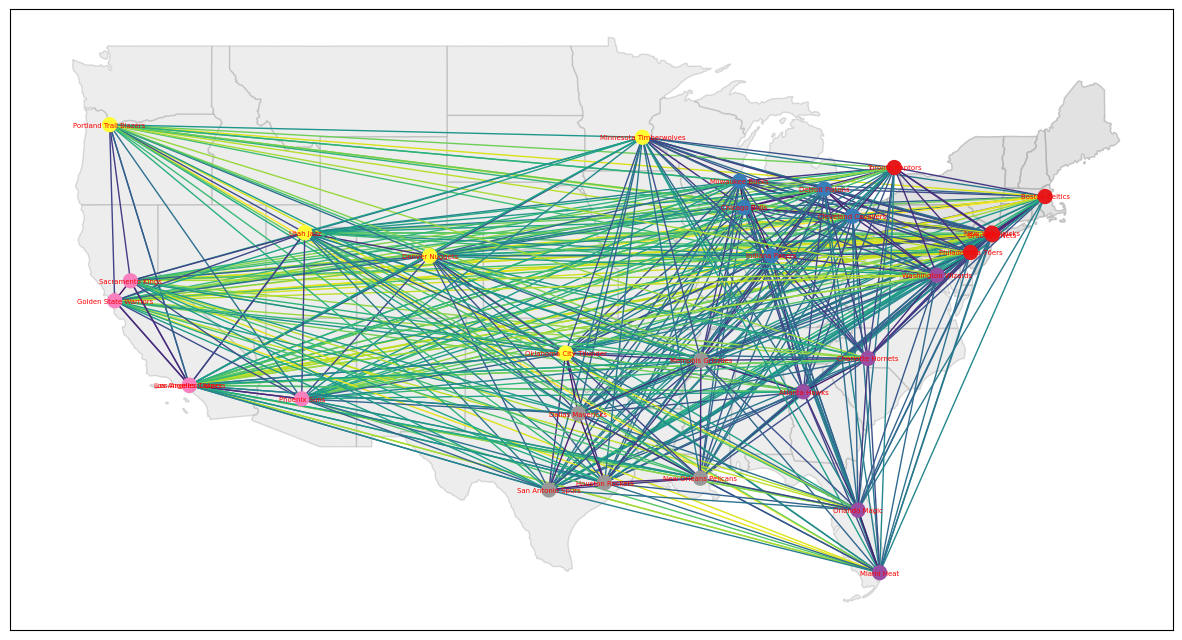

In [140]:
# Visualizing the adjacency matrix with the distances 

G_dist = nx.from_numpy_matrix(A_dist_as_weights)
G_dist = nx.relabel_nodes(G_dist, {k:v for k,v in zip(range(30), gdf["team_name"])})
coord = { r.team_name: [r.geometry.x, r.geometry.y] for i, r in gdf.iterrows()}
pos=coord
labels = nx.get_edge_attributes(G_dist, 'weight')

fig, ax = plt.subplots(figsize=(15,12))
ax.set_aspect('equal')
    
usa.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, pos, ax=ax, node_size=100, cmap=plt.cm.Set1, node_color=div_assignment)
nx.draw_networkx_labels(G_dist, pos, ax=ax, font_color="red", font_size=5)
nx.draw_networkx_edges(G_dist, pos, edge_color=labels.values())

In [141]:
# So basically for each division, I want to locate the edges where both nodes belong to that division
DIVISIONS = ["atlantic", "central", "southeast", "northwest", "pacific", "southwest"]

def distances_by_cluster_assignment(division_names, assignments):
    division_distances = list()
    for i, d in enumerate(division_names):
        d_indices = np.where(assignments == i)
        d_distances = np.triu(A_dist_as_weights[d_indices][:, d_indices][:, 0, :])
        d_distances = d_distances[d_distances != 0].flatten() # Remove diagonal (same team)
        division_distances.extend({ "division": d, "distance": dist} for dist in d_distances)
        division_distances.extend({ "division": "any", "distance": dist } for dist in d_distances)

    return pd.DataFrame(division_distances)


In [142]:
n2v = Node2Vec(G_dist, dimensions=8, walk_length=10, num_walks=1000, workers=10) 

Generating walks (CPU: 9): 100%|██████████| 100/100 [00:00<00:00, 1135.65it/s]


In [143]:
model = n2v.fit(window=1, min_count=1, batch_words=100)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

In [144]:
n_ids = model.wv.index_to_key 
n2v_embeddings = model.wv.vectors

n_df = pd.DataFrame([model.wv.get_vector(str(n)) for n in G_dist.nodes()], index=G_dist.nodes)

/opt/homebrew/Caskroom/mambaforge/base/envs/graph-based-data-sci/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/graph-based-data-sci/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


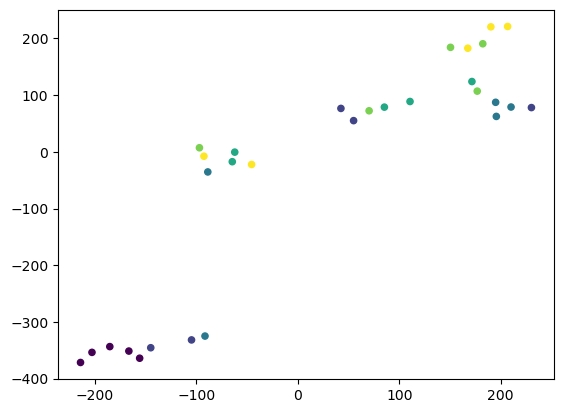

In [145]:
tsne = TSNE(n_components=2, perplexity=3)
n2v_embeddings_2d = tsne.fit_transform(n2v_embeddings)

plt.scatter(n2v_embeddings_2d[:,0], n2v_embeddings_2d[:,1], c=div_assignment, s=20)

In [171]:
spec = KMeans(n_clusters=2)
# s_cluster = spec.fit_predict(n_df)
s_cluster = conf_assignment


conf_dict = {gdf.iloc[i].team_name: j for i, j in enumerate(s_cluster)}

# Our goal is to assign 3 clusters per conference.
# Step 1: Filter the nodes into each conference
n_df = n_df.assign(conference=pd.Series(conf_dict))

# Step 2: Generate separate clustering for each conference
kmeans = KMeans(n_clusters=3)
conf_0 = n_df.query('conference == 0')
k_cluster_0 = kmeans.fit_predict(conf_0.drop(columns=["conference"]))

kmeans = KMeans(n_clusters=2)
conf_1 = n_df.query('conference == 1')
k_cluster_1 = kmeans.fit_predict(conf_1.drop(columns=["conference"]))

conf_0 = conf_0.assign(division=k_cluster_0)
conf_1 = conf_1.assign(division=k_cluster_1 + 3)

n_df = pd.concat((conf_0, conf_1))

/opt/homebrew/Caskroom/mambaforge/base/envs/graph-based-data-sci/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/graph-based-data-sci/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [173]:
nx.set_node_attributes(G_dist, n_df.division.to_dict(), "k_cluster")
div_clusters = [n_df.division.loc[i] for i in G_dist.nodes()]

nx.set_node_attributes(G_dist, conf_dict, "s_cluster")
conf_clusters = [n_df.conference.loc[i] for i in G_dist.nodes()]

In [174]:
n_df

,0,1,2,3,4,5,6,7,conference,division
Boston Celtics,-0.294360,0.086267,0.214540,0.604816,0.134433,0.019769,0.489777,-0.533069,0,0
Brooklyn Nets,-0.273941,0.133686,0.454587,0.520536,-0.033065,-0.067104,0.557847,-0.515782,0,0
New York Knicks,-0.335447,0.195515,0.347159,0.446894,0.116281,-0.105295,0.592354,-0.507376,0,0
Philadelphia 76ers,-0.317835,0.084957,0.343254,0.461451,0.106689,0.006730,0.582054,-0.498716,0,0
Miami Heat,0.225646,0.354932,0.126358,0.649782,0.249227,0.120449,0.392518,-0.550668,0,0
Orlando Magic,0.234626,0.162079,0.262318,0.463629,0.482968,0.267382,0.345886,-0.628028,0,0
Toronto Raptors,-0.494734,0.280134,0.339133,0.350977,0.146886,0.019500,0.373621,-0.557323,0,2
Chicago Bulls,-0.495054,0.460118,0.014129,0.169290,0.079062,0.165769,0.322571,-0.680936,0,2
Cleveland Cavaliers,-0.343201,0.278772,0.325028,0.375624,0.086193,-0.051345,0.465051,-0.589436,0,2
Detroit Pistons,-0.360172,0.382217,0.148033,0.244012,0.223625,-0.011999,0.457495,-0.624122,0,2


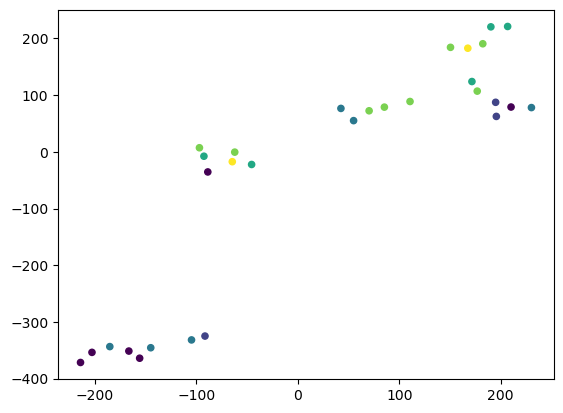

In [175]:
plt.scatter(n2v_embeddings_2d[:,0], n2v_embeddings_2d[:,1], c=div_clusters, s=20)

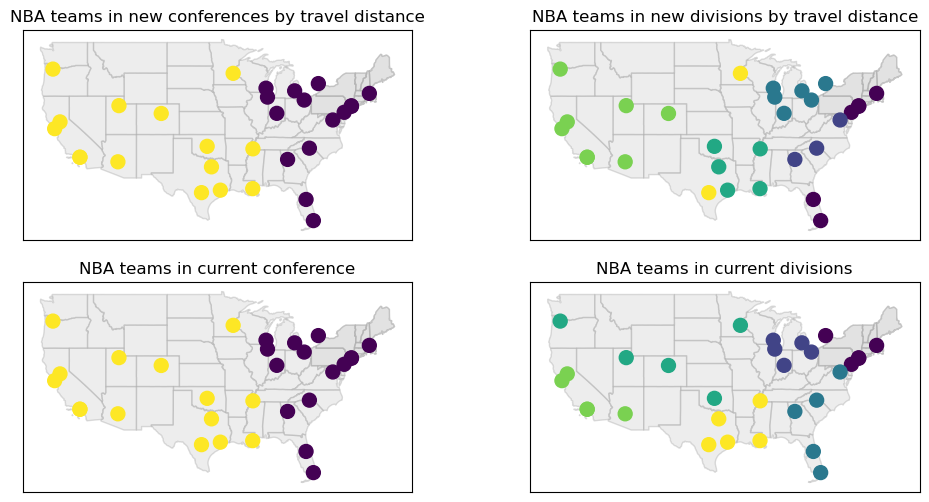

In [176]:
pos = coord
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
[ax1, ax3], [ax2, ax4] = axs
ax1.set_aspect('equal')
ax1.set_title('NBA teams in new conferences by travel distance')

usa.plot(ax=ax1, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, ax=ax1, pos=pos, node_size=100, node_color=conf_clusters)

ax2.set_aspect('equal')
ax2.set_title('NBA teams in current conference')

usa.plot(ax=ax2, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, ax=ax2, pos=pos, node_size=100, node_color=conf_assignment)

ax3.set_aspect('equal')
ax3.set_title('NBA teams in new divisions by travel distance')

usa.plot(ax=ax3, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, ax=ax3, pos=pos, node_size=100, node_color=div_clusters)

ax4.set_aspect('equal')
ax4.set_title('NBA teams in current divisions')

usa.plot(ax=ax4, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, ax=ax4, pos=pos, node_size=100, node_color=div_assignment)

Text(0.5, 1.0, 'Travel distances by current divisions')

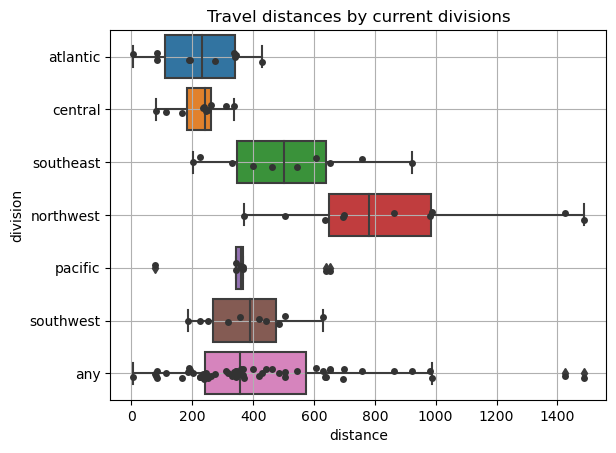

In [177]:
sns.boxplot(y="division", x="distance", order=DIVISIONS + ["any"], data=distances_by_cluster_assignment(DIVISIONS, div_assignment))
sns.stripplot(y="division", x="distance", order=DIVISIONS + ["any"], data=distances_by_cluster_assignment(DIVISIONS, div_assignment), color="0.2")
plt.grid()
plt.title("Travel distances by current divisions")

Text(0.5, 1.0, 'Travel distances by new divisions')

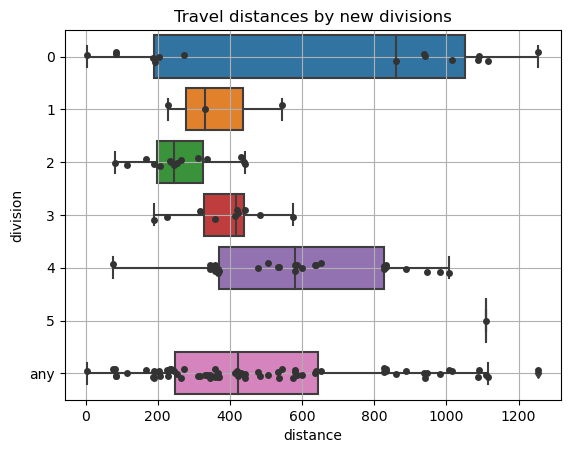

In [179]:
NEW_DIVISIONS = list(range(6))
sns.boxplot(y="division", x="distance", order=NEW_DIVISIONS + ["any"], data=distances_by_cluster_assignment(NEW_DIVISIONS, np.array(div_clusters)))
sns.stripplot(y="division", x="distance", order=NEW_DIVISIONS + ["any"], data=distances_by_cluster_assignment(NEW_DIVISIONS, np.array(div_clusters)), color="0.2")
plt.grid()
plt.title("Travel distances by new divisions")

# Minimizing travel distance through schedule

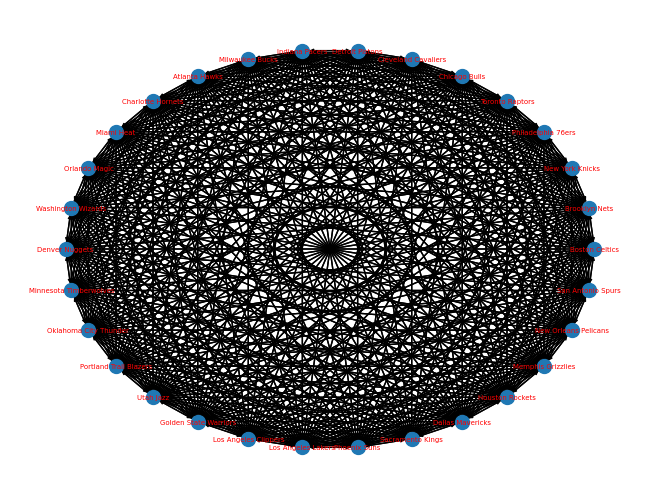

In [152]:
G_games = nx.from_numpy_matrix(A_num_games_as_weights, create_using=nx.DiGraph)
G_games = nx.relabel_nodes(G_games, {k:v for k,v in zip(range(30), gdf["team_name"])})

pos = nx.circular_layout(G_games)
nx.draw(G_games, pos=pos, with_labels=True, font_color='red', node_size=100, arrowsize=5, font_size=5)

In [153]:
A_total_dist = A_dist_as_weights@A_num_games_as_weights
distances_home = np.diag(A_total_dist)

In [154]:
dists = {k:v for k,v in zip(G_dist.nodes, distances_home)}
print(dists["Portland Trail Blazers"])

55207.0


In [155]:
print(A_total_dist[0])

[39551. 39169. 39175. 39003. 38691. 40453. 41057. 40915. 40545. 40443.
 41016. 41448. 40380. 40660. 42102. 43956. 45248. 44504. 42418. 43298.
 45897. 46097. 46097. 46693. 46031. 42783. 42675. 43613. 43167. 42359.]


In [156]:
print(A_dist_as_weights[0])

[   0.  191.  188.  274.  430.  853.  551.  622.  807.  858.  937.  721.
 1255. 1115.  394. 1770. 1124. 1496. 2539. 2099. 2698. 2598. 2598. 2300.
 2631. 1552. 1606. 1137. 1360. 1764.]


In [157]:
print(A_num_games_as_weights[:,1])

[2. 0. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


# Maximizing game attendance through schedule

In [158]:
attendance_df = pd.read_csv("attendance_data.csv")
attendance_df["Home_City"] = [gdf.loc[gdf["team_name"] == i]["city_name"].values[0] for i in attendance_df["Home/Neutral"]]
attendance_df

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Arena,Notes,Home_City
0,Tue Oct 16 2018,8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,NaN,18624,TD Garden,NaN,"Boston, MA"
1,Tue Oct 16 2018,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,19596,Oracle Arena,NaN,"San Francisco, CA"
2,Wed Oct 17 2018,7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,NaN,17889,Spectrum Center,NaN,"Charlotte, NC"
3,Wed Oct 17 2018,7:00p,Brooklyn Nets,100,Detroit Pistons,103,Box Score,NaN,20332,Little Caesars Arena,NaN,"Detroit, MI"
4,Wed Oct 17 2018,7:00p,Memphis Grizzlies,83,Indiana Pacers,111,Box Score,NaN,17923,Bankers Life Fieldhouse,NaN,"Indianapolis, IN"
...,...,...,...,...,...,...,...,...,...,...,...,...
1225,Wed Apr 10 2019,8:00p,Chicago Bulls,109,Philadelphia 76ers,125,Box Score,NaN,20197,Wells Fargo Center,NaN,"Philadelphia, PA"
1226,Wed Apr 10 2019,8:00p,Dallas Mavericks,94,San Antonio Spurs,105,Box Score,NaN,18629,AT&T Center,NaN,"San Antonio, TX"
1227,Wed Apr 10 2019,10:30p,Minnesota Timberwolves,95,Denver Nuggets,99,Box Score,NaN,16332,Pepsi Center,NaN,"Denver, CO"
1228,Wed Apr 10 2019,10:30p,Utah Jazz,137,Los Angeles Clippers,143,Box Score,OT,17655,STAPLES Center,NaN,"Los Angeles, CA"


In [159]:
edge_list_data = attendance_df[["Visitor/Neutral", "Home_City", "Attend."]]
edge_list_data

,Visitor/Neutral,Home_City,Attend.
0,Philadelphia 76ers,"Boston, MA",18624
1,Oklahoma City Thunder,"San Francisco, CA",19596
2,Milwaukee Bucks,"Charlotte, NC",17889
3,Brooklyn Nets,"Detroit, MI",20332
4,Memphis Grizzlies,"Indianapolis, IN",17923
...,...,...,...
1225,Chicago Bulls,"Philadelphia, PA",20197
1226,Dallas Mavericks,"San Antonio, TX",18629
1227,Minnesota Timberwolves,"Denver, CO",16332
1228,Utah Jazz,"Los Angeles, CA",17655


In [160]:
edge_list_data_agg = edge_list_data.groupby(["Visitor/Neutral", "Home_City"]).agg({"Attend.": "mean"}).reset_index()
edge_list_df = edge_list_data_agg.rename(columns={"Visitor/Neutral": "source", "Home_City": "target", "Attend.": "capacity"})
edge_list_df

,source,target,capacity
0,Atlanta Hawks,"Boston, MA",18624.0
1,Atlanta Hawks,"Charlotte, NC",13463.0
2,Atlanta Hawks,"Chicago, IL",19374.5
3,Atlanta Hawks,"Cleveland, OH",19432.0
4,Atlanta Hawks,"Dallas, TX",19643.0
...,...,...,...
809,Washington Wizards,"Sacramento, CA",14101.0
810,Washington Wizards,"Salt Lake City, UT",18306.0
811,Washington Wizards,"San Antonio, TX",18354.0
812,Washington Wizards,"San Francisco, CA",19596.0


In [161]:
sources = edge_list_df.groupby(['source']).mean().reset_index()
targets = edge_list_df.groupby(['target']).mean().reset_index()

In [162]:
print(sources["capacity"].values)

[17841.02777778 18592.41666667 17931.32142857 17590.16666667
 17849.76851852 17761.14197531 18091.53703704 17469.71296296
 17885.43518519 18861.35185185 17971.33333333 17676.84567901
 17332.23214286 19019.16071429 17754.93209877 18167.47222222
 18204.30555556 17739.62962963 17623.66666667 17617.125
 17853.04320988 17637.71604938 18048.16666667 17853.69444444
 17939.81481481 17200.75925926 17502.82407407 18167.15740741
 17724.33333333 17430.5462963 ]


In [163]:
G = nx.from_pandas_edgelist(edge_list_df, edge_attr=True, create_using=nx.DiGraph())

nodes = list(G.nodes)

s = 0
t = 0

for node in nodes:
    if node in edge_list_df["source"].values:
        G.add_edge('s', node, capacity=sources["capacity"][s])
        s += 1
    else:
        G.add_edge(node, 't', capacity=targets["capacity"][t])
        t += 1

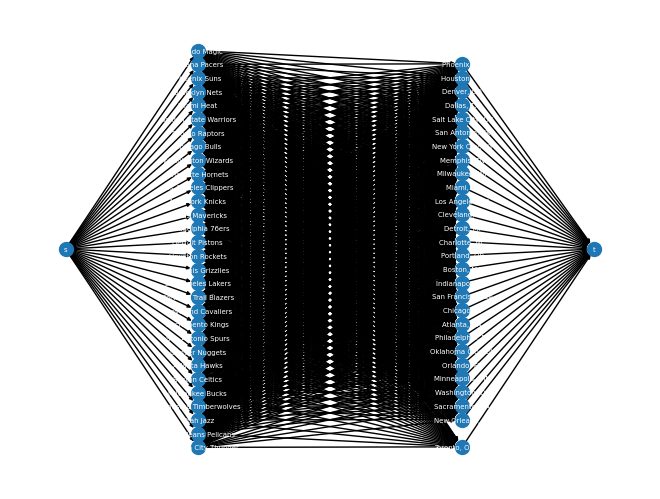

In [164]:
pos = flow_layout(G, 's', 't')
nx.draw(G, with_labels=True, font_color='white', node_size=100, arrowsize=5, font_size=5, pos=pos)

In [165]:
flow_value, flow_dict = nx.maximum_flow(G, 's', 't', capacity="capacity", flow_func=edmonds_karp)
print(flow_value)
print(flow_dict["Chicago Bulls"])

500618.2723180078
{'Atlanta, GA': 0, 'Boston, MA': 0, 'Charlotte, NC': 0, 'Cleveland, OH': 0, 'Dallas, TX': 17849.76851851852, 'Denver, CO': 0, 'Detroit, MI': 0, 'Houston, TX': 0, 'Indianapolis, IN': 0, 'Los Angeles, CA': 0, 'Memphis, TN': 0, 'Miami, FL': 0, 'Milwaukee, WI': 0, 'Minneapolis, MN': 0, 'New Orleans, LA': 0, 'New York City, NY': 0, 'Oklahoma City, OK': 0, 'Orlando, FL': 0, 'Philadelphia, PA': 0, 'Phoenix, AZ': 0, 'Portland, OR': 0, 'Sacramento, CA': 0, 'Salt Lake City, UT': 0, 'San Antonio, TX': 0, 'San Francisco, CA': 0, 'Toronto, Ontario': 0, 'Washington, DC': 0}


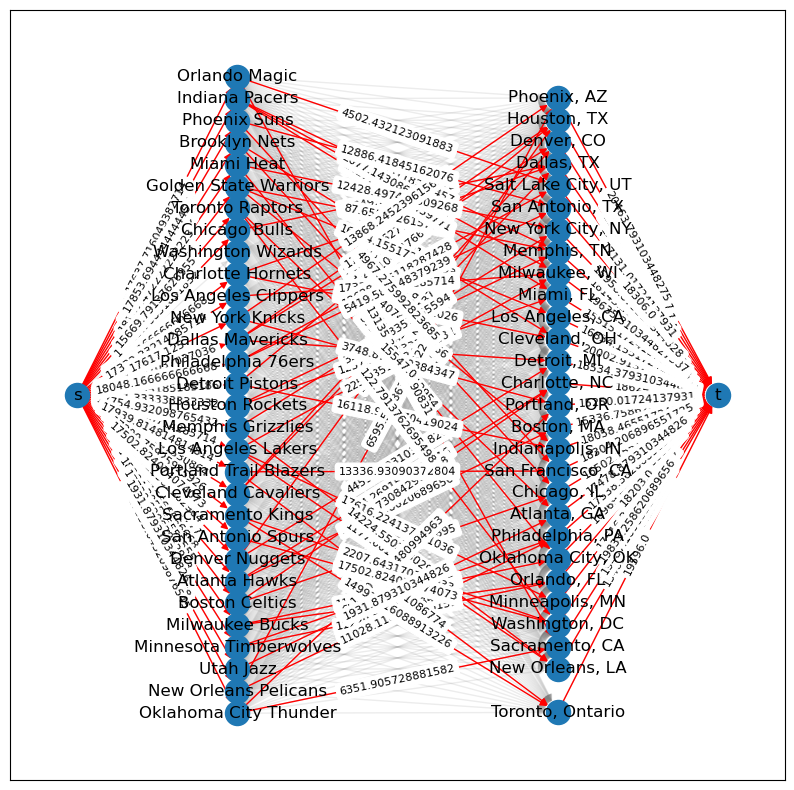

In [166]:
draw_flow(G, flowDict=flow_dict, fig_kwargs={"figsize":(10, 10)}, nx_kwargs={"font_size": 8})

In [167]:
# TODO: We have a big game day and we have 3 games that we can fit into the TV
# schedule that day. Let's extract the top 3 matchups that would maximize
# possible viewership.

In [168]:
# Get the three matchups that will generate the most attendance.
def n_best_matchups(n):
    return sorted(
        [
            (team_name, *sorted(flow_dict[team_name].items(), key=lambda it: it[1])[-1])
            for team_name in flow_dict["s"].keys()
        ],
        key=lambda it: it[2],
    )[-n:]

n_best_matchups(3)


[('Los Angeles Lakers', 'Minneapolis, MN', 17616.224137931036),
 ('Cleveland Cavaliers', 'Denver, CO', 17733.274067992457),
 ('Chicago Bulls', 'Dallas, TX', 17849.76851851852)]